## Changes to SPHERE System
### Andrew Attilio
#### 2024.07.21

We have a hierarchical system, where each object only sees the one below it in the hierarchy:

Model > Solver > Transition > Parameters > Individual Params

- The individual parameters (beta, gamma, etc.) are collected in a Parameters class. 

- The Transition takes in the Parameters. The Parameters parameterize the Transition equations. 

- The Solver takes in the Transition. The Solver needs the Transition functions to update the state. 

- The Model takes in the Solver. The Model needs the Solver to run and generate data. 

If the Model or solver needs some other sort of Hyper Parameters, they can be packaged in a different class/dictionary, rather than be lumped in with the current Parameters class.


### ModelFactory
The ModelFactory builds and returns a model, while also performing compatibility checks (SIRParameters go with SIR Transitions. Lorenz63 Params can't be used with SIR Transitions. etc.). This way, the Model class doesn't need to touch the Parameters just for validation --- that has already been done by the ModelFactory. 

The ModelFactory currently infers the type of process (Stochastic vs. Determinstic) by the type of Solver passed in. I'm not sure if this is ideal --- it can easily be changed if needed.

I haven't thought deeply about other processes (jump, tau-leap, etc.) but I believe they will fit in with this system. 

## Examples 

In [1]:
from sphere.model.model_factory import ModelFactory
from sphere.parameters.parameters import SIRParameters
from sphere.solvers.implementations import EulerSolver, EulerMaruyamaSolver
from sphere.parameters.functional_params import StepFunctionParam

beta_fun = StepFunctionParam(values=[0.3, 0.1], period=50)
SIR_params = SIRParameters(beta=beta_fun, gamma=0.2, population=10000)

SIR_det = ModelFactory.create_model(
    model_type="SIR", params=SIR_params, solver_cls=EulerSolver
)

In [11]:
SIR_det.run(x0=(9980, 20, 0), t0=0, t_final=100, dt=1.0)

Model.run() was successful. Data is accessible at Model.output.states. Plot the output with Model.output.plot_states().


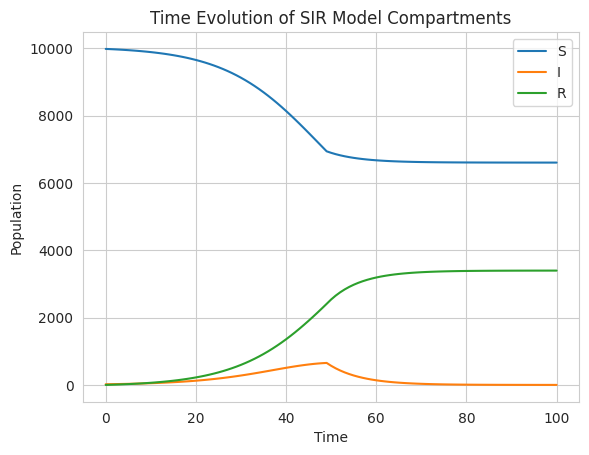

In [12]:
SIR_det.output.plot_states()

In [13]:
from sphere.parameters.parameters import Lorenz63Parameters

lorenz_params = Lorenz63Parameters(beta=8.0 / 3.0, sigma=10, rho=28)

In [14]:
lorenz = ModelFactory.create_model(
    model_type="Lorenz63", params=lorenz_params, solver_cls=EulerSolver
)

In [15]:
lorenz.run(x0=(1.0, 1.0, 1.0), t0=0, t_final=50, dt=0.01)

Model.run() was successful. Data is accessible at Model.output.states. Plot the output with Model.output.plot_states().


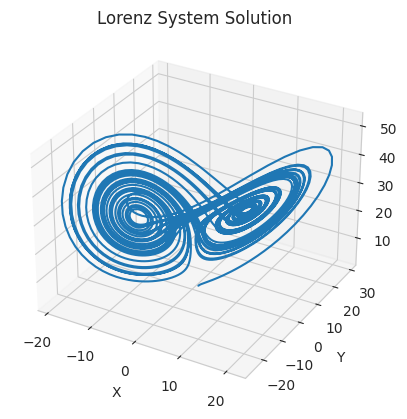

In [16]:
lorenz.output.plot_states()

In [17]:
SIR_sto = ModelFactory.create_model(
    model_type="SIR", params=SIR_params, solver_cls=EulerMaruyamaSolver
)

In [18]:
SIR_sto.run(x0=(9980, 20, 0), t0=0, t_final=100, dt=1.0)

Model.run() was successful. Data is accessible at Model.output.states. Plot the output with Model.output.plot_states().


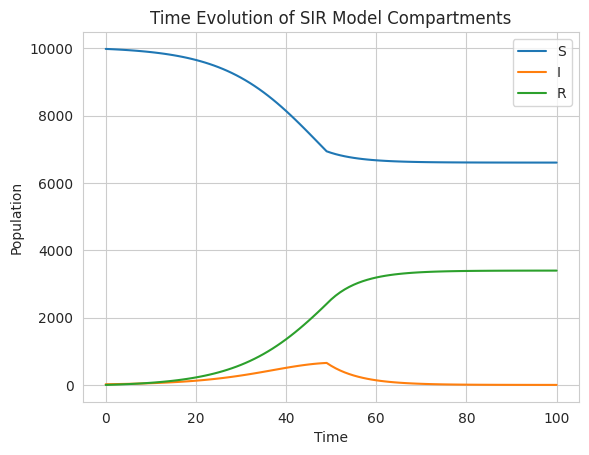

In [19]:
SIR_sto.output.plot_states()

Possible issues/improvements:
- For SIR, should `Parameters.population` be calculated from the initial state that the user passes in the `model.run()` method?
- Currently removed the idea of a 'RUME' and pretty much replace it with the ModelFactory. We might want a 'RUME' later to combine Models with Filters or other components of an experiment.
- We need controlled random number generation with JAX PRNG keys for the Stochastic transitions/solvers. I don't think I'm currently implementing this correctly (see StochasticSolver) -- I need to do more research. It's different than NumPy.  
- I need to write tests for all of these new classes. But, I want to wait until I receive feedback from the rest of the team to make sure that we have a good base here.
- Type and length validation for initial state.
- The output is stored at every intermediate time step. So, if dt=0.5, then the output.plot_states() displays 200 ticks on the x-axis for a 100-day process.